In [2]:
import math, os, random, time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

def set_seed(s=42):
    random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Data
transform = transforms.Compose([
    transforms.ToTensor(),                    # [0,1]
    # FashionMNIST is grayscale 28x28 already
])

train_set = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
val_set   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#  Model

from architecture import VAE
model = VAE().to(device)

#  Loss: MSE recon + KL
mse = nn.MSELoss(reduction="sum")   # sum over pixels will be divided by batch later

def kl_normal_standard(mu, logvar):
    # KL( N(mu, diag(sigma^2)) || N(0, I) ) = -1/2 * sum(1 + logvar - mu^2 - exp(logvar))
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def elbo_components(x, recon, mu, logvar):
    recon_loss = mse(recon, x)  # sum over all pixels and batch
    kl = kl_normal_standard(mu, logvar)
    return recon_loss, kl

#  Optimizer
opt = optim.Adam(model.parameters(), lr=2e-3)

#  Grad clip to stabilize training
GRAD_CLIP = 5.0

#  Train/Val loops
def run_epoch(loader, train=True, beta=1.0):
    model.train(train)
    total_rec, total_kl, total = 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        rec, kl = elbo_components(x, recon, mu, logvar)
        # Average per-sample so logs are comparable across batch sizes
        loss = (rec + beta * kl) / x.size(0)

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            if GRAD_CLIP: nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            opt.step()

        total_rec += rec.item()
        total_kl  += kl.item()
        total     += x.size(0)

    # report per-sample averages
    return (total_rec/total, total_kl/total, (total_rec + beta*total_kl)/total)

EPOCHS = 30
history = {"train_rec":[], "train_kl":[], "train_total":[],
           "val_rec":[], "val_kl":[], "val_total":[], "beta":[]}

# simple constant beta=1 training for Task 1
for epoch in range(1, EPOCHS+1):
    beta = 1.0
    tr_rec, tr_kl, tr_tot = run_epoch(train_loader, train=True,  beta=beta)
    va_rec, va_kl, va_tot = run_epoch(val_loader,   train=False, beta=beta)

    history["beta"].append(beta)
    history["train_rec"].append(tr_rec)
    history["train_kl"].append(tr_kl)
    history["train_total"].append(tr_tot)
    history["val_rec"].append(va_rec)
    history["val_kl"].append(va_kl)
    history["val_total"].append(va_tot)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"beta={beta:.3f} | "
          f"Train: rec {tr_rec:.2f} kl {tr_kl:.2f} tot {tr_tot:.2f} || "
          f"Val:   rec {va_rec:.2f} kl {va_kl:.2f} tot {va_tot:.2f}")

# Save logs and model
os.makedirs("artifacts", exist_ok=True)
torch.save({"model": model.state_dict(), "history": history}, "artifacts/vae_fmnist.pt")


[01/30] beta=1.000 | Train: rec 28.63 kl 6.13 tot 34.76 || Val:   rec 20.83 kl 6.97 tot 27.80
[02/30] beta=1.000 | Train: rec 19.45 kl 6.95 tot 26.39 || Val:   rec 18.84 kl 6.95 tot 25.79
[03/30] beta=1.000 | Train: rec 18.05 kl 7.22 tot 25.27 || Val:   rec 18.38 kl 6.69 tot 25.06
[04/30] beta=1.000 | Train: rec 17.37 kl 7.33 tot 24.70 || Val:   rec 17.73 kl 7.08 tot 24.81
[05/30] beta=1.000 | Train: rec 16.99 kl 7.42 tot 24.40 || Val:   rec 16.76 kl 7.59 tot 24.35
[06/30] beta=1.000 | Train: rec 16.66 kl 7.51 tot 24.17 || Val:   rec 16.51 kl 7.66 tot 24.17
[07/30] beta=1.000 | Train: rec 16.43 kl 7.56 tot 23.98 || Val:   rec 16.57 kl 7.37 tot 23.93
[08/30] beta=1.000 | Train: rec 16.26 kl 7.60 tot 23.86 || Val:   rec 16.02 kl 7.78 tot 23.80
[09/30] beta=1.000 | Train: rec 16.10 kl 7.65 tot 23.75 || Val:   rec 16.45 kl 7.31 tot 23.75
[10/30] beta=1.000 | Train: rec 15.91 kl 7.68 tot 23.60 || Val:   rec 16.07 kl 7.62 tot 23.69
[11/30] beta=1.000 | Train: rec 15.75 kl 7.77 tot 23.52 || V

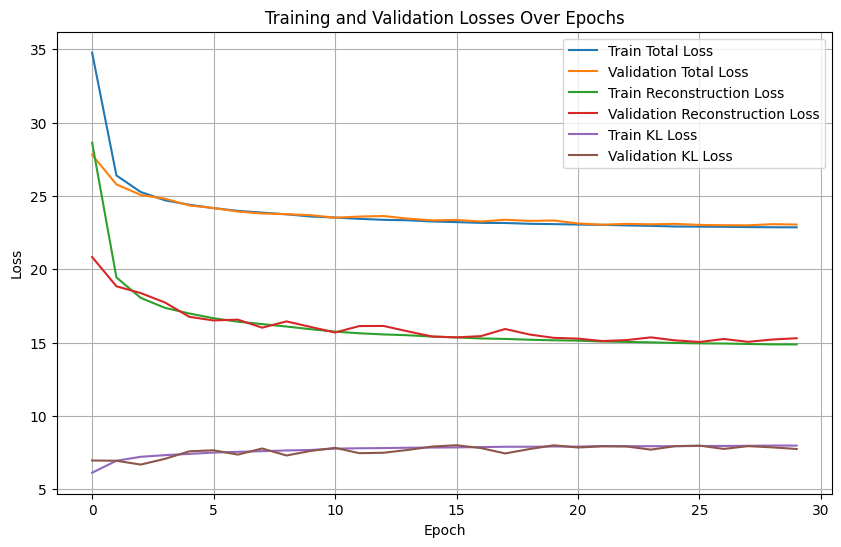

In [3]:
# Plot history
plt.figure(figsize=(10, 6))
plt.plot(history['train_total'], label='Train Total Loss')
plt.plot(history['val_total'], label='Validation Total Loss')
plt.plot(history['train_rec'], label='Train Reconstruction Loss')
plt.plot(history['val_rec'], label='Validation Reconstruction Loss')
plt.plot(history['train_kl'], label='Train KL Loss')
plt.plot(history['val_kl'], label='Validation KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

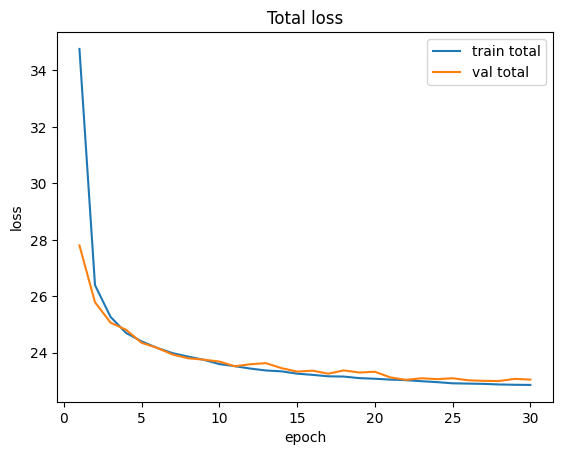

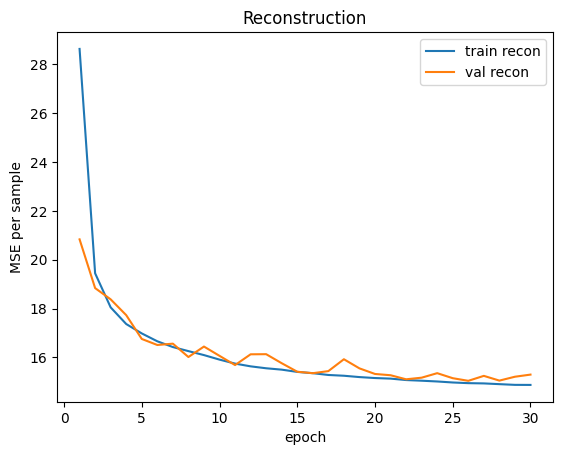

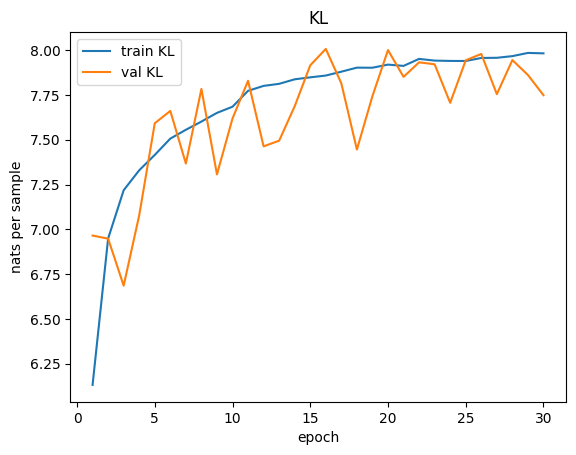

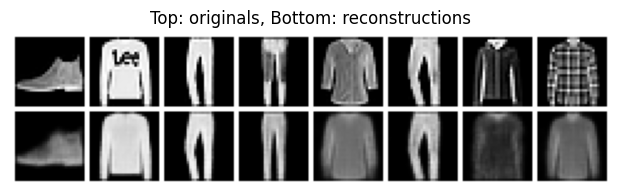

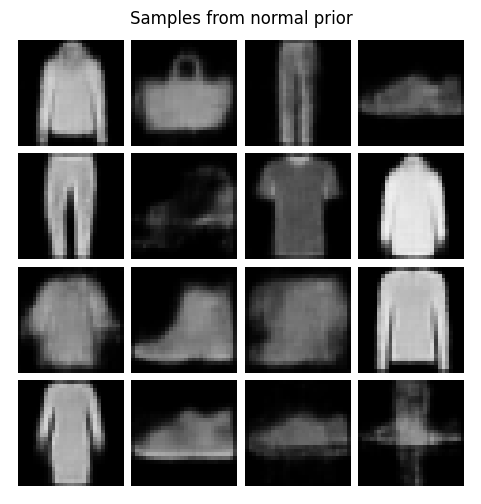

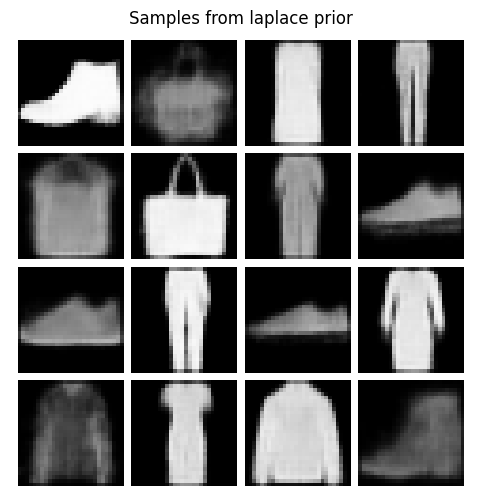

In [4]:
@torch.no_grad()
def show_reconstructions(n=8):
    model.eval()
    x, _ = next(iter(val_loader))
    x = x[:n].to(device)
    recon, _, _ = model(x)
    grid = vutils.make_grid(torch.cat([x, recon], dim=0), nrow=n, pad_value=1.0)
    plt.figure(figsize=(n, 2))
    plt.axis("off"); plt.title("Top: originals, Bottom: reconstructions")
    plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap="gray")
    plt.show()

@torch.no_grad()
def sample_from_prior(n=16, prior="normal"):
    model.eval()
    # infer latent dim from mu during a forward pass on a tiny batch
    x, _ = next(iter(val_loader))
    x = x[:1].to(device)
    _, mu, _ = model(x)
    zdim = mu.shape[1]

    if prior == "normal":
        z = torch.randn(n, zdim, device=device)
    elif prior == "laplace":
        # Laplace(0,1).sample()
        lap = torch.distributions.Laplace(loc=torch.zeros(zdim, device=device), scale=torch.ones(zdim, device=device))
        z = lap.sample((n,))
    else:
        raise ValueError("prior must be 'normal' or 'laplace'")

    # decode-only path: assuming VAE has a decode(z) or decoder(z)
    if hasattr(model, "decode"):
        imgs = model.decode(z)
    else:
        # If architecture exposes a 'decoder' module
        imgs = model.decoder(z)

    grid = vutils.make_grid(imgs, nrow=int(math.sqrt(n)), pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.axis("off"); plt.title(f"Samples from {prior} prior")
    plt.imshow(grid.cpu().permute(1,2,0).squeeze(), cmap="gray")
    plt.show()

def plot_losses(history):
    xs = range(1, len(history["train_total"])+1)
    plt.figure(); plt.plot(xs, history["train_total"], label="train total")
    plt.plot(xs, history["val_total"],   label="val total"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Total loss")
    plt.figure(); plt.plot(xs, history["train_rec"], label="train recon")
    plt.plot(xs, history["val_rec"],   label="val recon"); plt.xlabel("epoch"); plt.ylabel("MSE per sample"); plt.legend(); plt.title("Reconstruction")
    plt.figure(); plt.plot(xs, history["train_kl"], label="train KL")
    plt.plot(xs, history["val_kl"],   label="val KL"); plt.xlabel("epoch"); plt.ylabel("nats per sample"); plt.legend(); plt.title("KL")
    plt.show()

# call after training:
plot_losses(history)
show_reconstructions(n=8)
sample_from_prior(n=16, prior="normal")
sample_from_prior(n=16, prior="laplace")


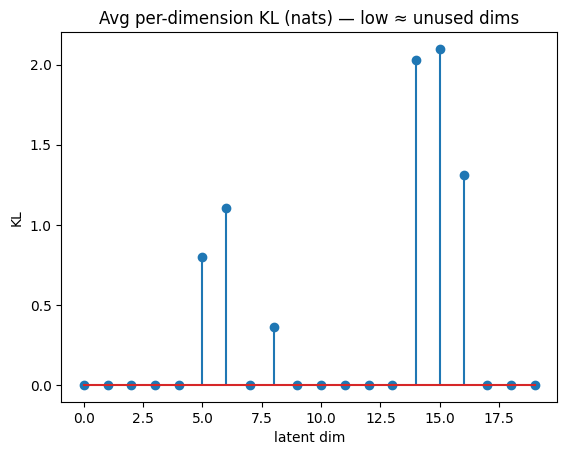

Mean |mu| across dims (lower ≈ closer to prior mean):
[0.01753526 0.04362604 0.0040834  0.0031585  0.02009211 0.07844752
 0.03521003 0.02037184 0.06009704 0.02184301 0.00939641 0.02512023
 0.01715139 0.03444309 0.07379159 0.04893012 0.0531049  0.01131726
 0.00419823 0.02459726]
Mean logvar across dims (≈0 means var ~ 1):
[-2.0975057e-02 -1.3847530e-02 -5.6832889e-03 -7.7015832e-03
 -2.6408961e-02 -1.6777885e+00 -2.2694016e+00 -2.0041941e-03
 -7.3168087e-01  2.5753400e-03 -2.2047838e-02 -2.9426817e-02
 -8.5356021e-03 -2.3386558e-03 -4.1056337e+00 -4.1835051e+00
 -2.6950746e+00 -7.3109358e-04 -4.6359818e-02 -6.1994134e-03]
Total KL per sample (approx): 7.724 nats


In [5]:
@torch.no_grad()
def latent_diagnostics(loader, max_batches=10):
    model.eval()
    kls, mus, logvars = [], [], []
    batches = 0
    for x, _ in loader:
        x = x.to(device)
        _, mu, logvar = model(x)
        # per-dimension KL for diagnostics: 0.5*(mu^2 + exp(logvar) - 1 - logvar)
        per_dim_kl = 0.5*(mu.pow(2) + logvar.exp() - 1.0 - logvar)
        kls.append(per_dim_kl.mean(dim=0).cpu())  # average over batch
        mus.append(mu.mean(dim=0).abs().cpu())
        logvars.append(logvar.mean(dim=0).cpu())
        batches += 1
        if batches >= max_batches: break
    kls = torch.stack(kls).mean(0)
    mus = torch.stack(mus).mean(0)
    logvars = torch.stack(logvars).mean(0)

    plt.figure(); plt.stem(kls.numpy())
    plt.title("Avg per-dimension KL (nats) — low ≈ unused dims"); plt.xlabel("latent dim"); plt.ylabel("KL")
    plt.show()

    print("Mean |mu| across dims (lower ≈ closer to prior mean):")
    print(mus.numpy())
    print("Mean logvar across dims (≈0 means var ~ 1):")
    print(logvars.numpy())
    print(f"Total KL per sample (approx): {kls.sum().item():.3f} nats")

# usage
latent_diagnostics(val_loader)

In [6]:
def sigmoid_anneal(t, t0=5, k=0.5):
    # smooth increase from ~0 to ~1 over epochs; tune t0 (midpoint) and k (slope)
    return float(1 / (1 + math.exp(-k*(t - t0))))

def linear_anneal(epoch, start=0, end=1, warmup_epochs=10):
    if epoch <= warmup_epochs:
        return start + (end-start) * (epoch / warmup_epochs)
    return end

# Re-run training with annealed beta
model = VAE().to(device)
opt = optim.Adam(model.parameters(), lr=2e-3)
history2 = {k:[] for k in history.keys()}

EPOCHS = 40
WARMUP = 15  # try 10–30
for epoch in range(1, EPOCHS+1):
    beta = linear_anneal(epoch, start=0.0, end=1.0, warmup_epochs=WARMUP)
    tr_rec, tr_kl, tr_tot = run_epoch(train_loader, train=True,  beta=beta)
    va_rec, va_kl, va_tot = run_epoch(val_loader,   train=False, beta=beta)

    history2["beta"].append(beta)
    history2["train_rec"].append(tr_rec); history2["train_kl"].append(tr_kl); history2["train_total"].append(tr_tot)
    history2["val_rec"].append(va_rec);   history2["val_kl"].append(va_kl);   history2["val_total"].append(va_tot)

    print(f"[{epoch:02d}/{EPOCHS}] beta={beta:.3f} | "
          f"Train rec {tr_rec:.2f} kl {tr_kl:.2f} tot {tr_tot:.2f} || "
          f"Val rec {va_rec:.2f} kl {va_kl:.2f} tot {va_tot:.2f}")

torch.save({"model": model.state_dict(), "history": history2}, "artifacts/vae_fmnist_warmup.pt")


[01/40] beta=0.067 | Train rec 24.96 kl 26.05 tot 26.69 || Val rec 15.68 kl 28.73 tot 17.60
[02/40] beta=0.133 | Train rec 14.68 kl 22.60 tot 17.70 || Val rec 13.36 kl 22.20 tot 16.32
[03/40] beta=0.200 | Train rec 13.25 kl 19.08 tot 17.06 || Val rec 12.50 kl 19.21 tot 16.35
[04/40] beta=0.267 | Train rec 12.74 kl 17.08 tot 17.30 || Val rec 12.80 kl 16.50 tot 17.20
[05/40] beta=0.333 | Train rec 12.71 kl 15.60 tot 17.91 || Val rec 12.38 kl 16.27 tot 17.80
[06/40] beta=0.400 | Train rec 12.79 kl 14.41 tot 18.55 || Val rec 12.68 kl 14.68 tot 18.55
[07/40] beta=0.467 | Train rec 12.97 kl 13.35 tot 19.20 || Val rec 13.14 kl 12.82 tot 19.12
[08/40] beta=0.533 | Train rec 13.18 kl 12.43 tot 19.81 || Val rec 12.80 kl 12.96 tot 19.71
[09/40] beta=0.600 | Train rec 13.43 kl 11.75 tot 20.49 || Val rec 13.30 kl 11.90 tot 20.44
[10/40] beta=0.667 | Train rec 13.74 kl 11.08 tot 21.12 || Val rec 13.57 kl 11.25 tot 21.07
[11/40] beta=0.733 | Train rec 14.01 kl 10.56 tot 21.76 || Val rec 14.14 kl 10.2

In [7]:
def kl_free_bits(mu, logvar, lam=0.8):
    # per-dim KL
    per_dim = 0.5*(mu.pow(2) + logvar.exp() - 1.0 - logvar)
    # apply floor then sum
    return torch.sum(torch.clamp(per_dim.mean(dim=0), min=lam))

# swap in the training step:
def elbo_components_freebits(x, recon, mu, logvar, lam=0.8):
    rec = mse(recon, x)
    kl  = kl_free_bits(mu, logvar, lam=lam)
    return rec, kl


In [8]:
enc_params = list(model.encoder.parameters()) if hasattr(model, "encoder") else []
dec_params = list(model.decoder.parameters()) if hasattr(model, "decoder") else []
opt = optim.Adam([
    {"params": enc_params, "lr": 3e-3},
    {"params": dec_params, "lr": 1.5e-3},
    # add any other params (e.g., final heads) accordingly
])


In [9]:
# --- Imports & setup (posterior collapse section) ---
import math, os, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

device = globals().get("device", "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [10]:
# --- Data (reuse if available) ---
if "train_loader" in globals() and "val_loader" in globals():
    print("Reusing existing train_loader / val_loader")
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # [-1,1] scale matches tanh decoders; still fine with MSE
    ])
    train_set = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
    val_set   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
    print("Created train/val loaders:", len(train_set), len(val_set))


Reusing existing train_loader / val_loader


In [ ]:
LATENT_DIM = globals().get("LATENT_DIM", 20)

if "VAE" in globals():
    print("Reusing existing VAE class.")
else:
    class PC_Encoder(nn.Module):
        def __init__(self, z_dim=LATENT_DIM):
            super().__init__()
            self.conv = nn.Sequential(
                nn.Conv2d(1, 32, 4, 2, 1), nn.ReLU(True),   # 28->14
                nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(True),  # 14->7
                nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True)  # 7->7
            )
            self.fc_mu = nn.Linear(128*7*7, z_dim)
            self.fc_logvar = nn.Linear(128*7*7, z_dim)
        def forward(self, x):
            h = self.conv(x)
            h = h.view(x.size(0), -1)
            mu = self.fc_mu(h)
            logvar = self.fc_logvar(h)
            return mu, logvar

    class PC_Decoder(nn.Module):
        def __init__(self, z_dim=LATENT_DIM):
            super().__init__()
            self.fc = nn.Linear(z_dim, 128*7*7)
            self.deconv = nn.Sequential(
                nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(True), # 7->14
                nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(True),  # 14->28
                nn.Conv2d(32, 1, 3, 1, 1)  # logits for MSE; if using tanh, wrap outside
            )
        def forward(self, z):
            h = self.fc(z).view(z.size(0), 128, 7, 7)
            x_hat = self.deconv(h)
            return x_hat

    class VAE(nn.Module):
        def __init__(self, z_dim=LATENT_DIM):
            super().__init__()
            self.enc = PC_Encoder(z_dim)
            self.dec = PC_Decoder(z_dim)
        def encode(self, x):
            return self.enc(x)
        def reparameterize(self, mu, logvar):
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return mu + eps*std
        def decode(self, z):
            return self.dec(z)
        def forward(self, x):
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            x_hat = self.decode(z)
            return x_hat, mu, logvar
    print("Defined minimal PC_VAE classes.")

def count_params(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)


Reusing existing VAE class.


In [12]:
# --- Loss helpers & metrics ---
def mse_recon(x, x_hat):
    return F.mse_loss(x_hat, x, reduction='mean') * x.size(1)  # keep comparable scale per-sample

def kl_diag_gauss(mu, logvar):
    # KL(q||p) where p=N(0,1), per-sample sum over dims
    return 0.5 * torch.sum(mu.pow(2) + torch.exp(logvar) - logvar - 1, dim=1)

def kl_per_dim(mu, logvar):
    # mean over batch, per-dim
    return 0.5 * (mu.pow(2) + torch.exp(logvar) - logvar - 1).mean(dim=0)

@torch.no_grad()
def active_units(kl_dim, threshold=0.02):
    # kl_dim: per-dim mean KL (tensor [D])
    return int((kl_dim > threshold).sum().item())

def make_beta_warmup(total_epochs, warm_epochs):
    def schedule(epoch_idx):
        # epoch_idx is 1-based when called inside loop below
        return min(1.0, epoch_idx / max(1, warm_epochs))
    return schedule

def identity_beta(_): return 1.0

def free_bits_adjust(kl_dim, fb_lambda=0.0):
    # clamp per-dim mean KL to minimum lambda before summing
    if fb_lambda <= 0:
        return kl_dim.sum()
    return torch.clamp(kl_dim, min=fb_lambda).sum()


In [13]:
# --- Training loop (reusable) ---
def run_experiment(name="baseline", epochs=10, beta_schedule=identity_beta, fb_lambda=0.0, lr=2e-3, z_dim=LATENT_DIM):
    vae = VAE(z_dim).to(device)
    opt = torch.optim.Adam(vae.parameters(), lr=lr)
    history = {"epoch": [], "train_recon": [], "train_kl": [], "val_recon": [], "val_kl": [],
               "active_dims": [], "beta": []}
    print(f"\n==> Starting {name} | epochs={epochs}, fb_lambda={fb_lambda}")
    print("VAE trainable params:", count_params(vae))

    for epoch in range(1, epochs+1):
        vae.train()
        tr_recon, tr_kl, n = 0.0, 0.0, 0
        beta = beta_schedule(epoch)
        for x, _ in train_loader:
            x = x.to(device)
            opt.zero_grad()
            x_hat, mu, logvar = vae(x)
            recon = mse_recon(x, x_hat)
            kl_dim = kl_per_dim(mu, logvar)   # per-dim mean over batch
            kl_total = free_bits_adjust(kl_dim, fb_lambda)  # sum over dims
            loss = recon + beta * kl_total / x.size(0)      # normalize by batch to keep per-sample scale
            loss.backward()
            opt.step()
            tr_recon += recon.item() * x.size(0)
            tr_kl    += (0.5 * torch.sum(mu.pow(2) + torch.exp(logvar) - logvar - 1, dim=1)).mean().item() * x.size(0)
            n += x.size(0)

        # Validation
        vae.eval()
        va_recon, va_kl, m = 0.0, 0.0, 0
        kl_dim_accum = []
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                x_hat, mu, logvar = vae(x)
                recon = mse_recon(x, x_hat)
                kl = 0.5 * torch.sum(mu.pow(2) + torch.exp(logvar) - logvar - 1, dim=1).mean()
                va_recon += recon.item() * x.size(0)
                va_kl    += kl.item() * x.size(0)
                kl_dim_accum.append(kl_per_dim(mu, logvar).cpu())
                m += x.size(0)
        kl_dim_mean = torch.stack(kl_dim_accum).mean(dim=0)
        act = active_units(kl_dim_mean)

        history["epoch"].append(epoch)
        history["train_recon"].append(tr_recon / n)
        history["train_kl"].append(tr_kl / n)
        history["val_recon"].append(va_recon / m)
        history["val_kl"].append(va_kl / m)
        history["active_dims"].append(act)
        history["beta"].append(beta)

        print(f"[{name}] Epoch {epoch:02d} | beta={beta:.3f} | recon {tr_recon/n:.3f}/{va_recon/m:.3f} | KL {tr_kl/n:.3f}/{va_kl/m:.3f} | active={act}")
    return vae, history


In [14]:
# --- Run baseline (β=1) and mitigation (warm-up + free-bits) ---
EPOCHS = 15
WARM = 10                 # warm-up epochs for mitigation
FREE_BITS = 0.05          # per-dim minimum nats (try 0.02–0.2)

vae_base, hist_base = run_experiment(name="baseline_beta1", epochs=EPOCHS, beta_schedule=identity_beta, fb_lambda=0.0)
vae_warm, hist_warm = run_experiment(name="mitigated_warm_freebits", epochs=EPOCHS, beta_schedule=make_beta_warmup(EPOCHS, WARM), fb_lambda=FREE_BITS)



==> Starting baseline_beta1 | epochs=15, fb_lambda=0.0
VAE trainable params: 1691369
[baseline_beta1] Epoch 01 | beta=1.000 | recon 0.059/0.045 | KL 1.496/2.079 | active=3
[baseline_beta1] Epoch 02 | beta=1.000 | recon 0.044/0.044 | KL 2.182/2.102 | active=4
[baseline_beta1] Epoch 03 | beta=1.000 | recon 0.042/0.041 | KL 2.309/2.291 | active=4
[baseline_beta1] Epoch 04 | beta=1.000 | recon 0.041/0.041 | KL 2.377/2.266 | active=4
[baseline_beta1] Epoch 05 | beta=1.000 | recon 0.040/0.041 | KL 2.411/2.347 | active=4
[baseline_beta1] Epoch 06 | beta=1.000 | recon 0.040/0.039 | KL 2.439/2.430 | active=4
[baseline_beta1] Epoch 07 | beta=1.000 | recon 0.039/0.040 | KL 2.474/2.380 | active=4
[baseline_beta1] Epoch 08 | beta=1.000 | recon 0.039/0.039 | KL 2.490/2.544 | active=4
[baseline_beta1] Epoch 09 | beta=1.000 | recon 0.039/0.039 | KL 2.500/2.430 | active=4
[baseline_beta1] Epoch 10 | beta=1.000 | recon 0.039/0.039 | KL 2.496/2.382 | active=4
[baseline_beta1] Epoch 11 | beta=1.000 | rec

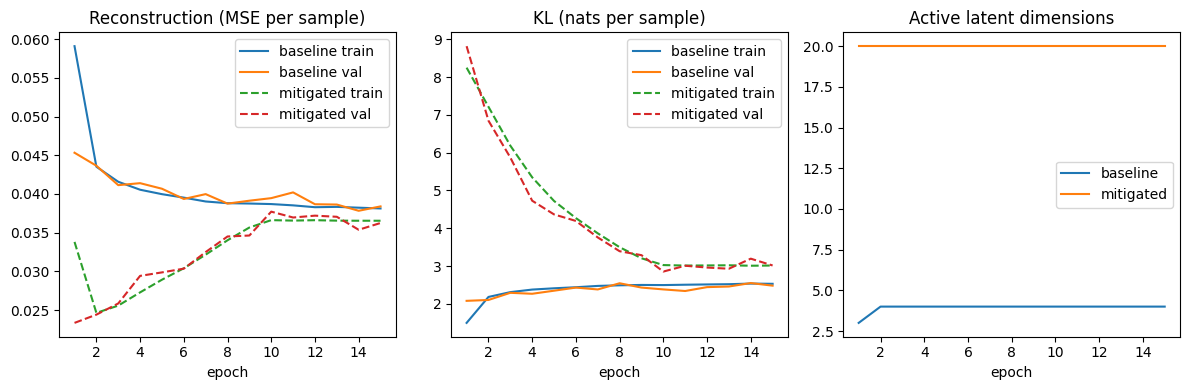

In [15]:
# --- Plot histories ---
def plot_histories(hist_a, label_a, hist_b, label_b):
    ep = hist_a["epoch"]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(ep, hist_a["train_recon"], label=f"{label_a} train")
    plt.plot(ep, hist_a["val_recon"], label=f"{label_a} val")
    plt.plot(ep, hist_b["train_recon"], label=f"{label_b} train", linestyle="--")
    plt.plot(ep, hist_b["val_recon"], label=f"{label_b} val", linestyle="--")
    plt.title("Reconstruction (MSE per sample)"); plt.xlabel("epoch"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(ep, hist_a["train_kl"], label=f"{label_a} train")
    plt.plot(ep, hist_a["val_kl"], label=f"{label_a} val")
    plt.plot(ep, hist_b["train_kl"], label=f"{label_b} train", linestyle="--")
    plt.plot(ep, hist_b["val_kl"], label=f"{label_b} val", linestyle="--")
    plt.title("KL (nats per sample)"); plt.xlabel("epoch"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(ep, hist_a["active_dims"], label=f"{label_a}")
    plt.plot(ep, hist_b["active_dims"], label=f"{label_b}")
    plt.title("Active latent dimensions"); plt.xlabel("epoch"); plt.legend()
    plt.tight_layout()
    plt.show()

plot_histories(hist_base, "baseline", hist_warm, "mitigated")


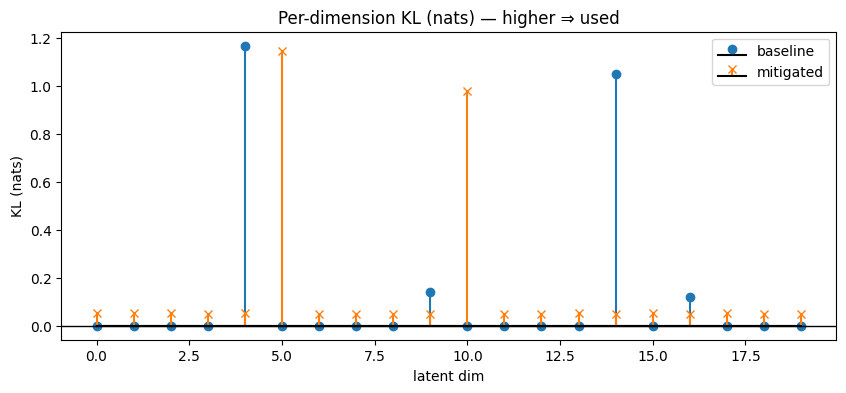

Active dims — baseline: 4
Active dims — mitigated: 20


In [17]:
# --- Per-dimension KL at the end of training for each experiment ---
@torch.no_grad()
def kl_dim_for_model(vae, loader):
    vae.eval()
    acc = []
    for x, _ in loader:
        x = x.to(device)
        _, mu, logvar = vae(x)
        acc.append(kl_per_dim(mu, logvar).cpu())
    return torch.stack(acc).mean(dim=0)

kl_base = kl_dim_for_model(vae_base, val_loader)
kl_warm = kl_dim_for_model(vae_warm, val_loader)

plt.figure(figsize=(10,4))
plt.stem(kl_base.numpy(), linefmt='C0-', markerfmt='C0o', basefmt='k-', label="baseline")
plt.stem(kl_warm.numpy(), linefmt='C1-', markerfmt='C1x', basefmt='k-', label="mitigated")
plt.axhline(0, color='k', lw=1)
plt.title("Per-dimension KL (nats) — higher ⇒ used")
plt.xlabel("latent dim"); plt.ylabel("KL (nats)"); plt.legend(); plt.show()

print("Active dims — baseline:", int((kl_base>0.02).sum()))
print("Active dims — mitigated:", int((kl_warm>0.02).sum()))

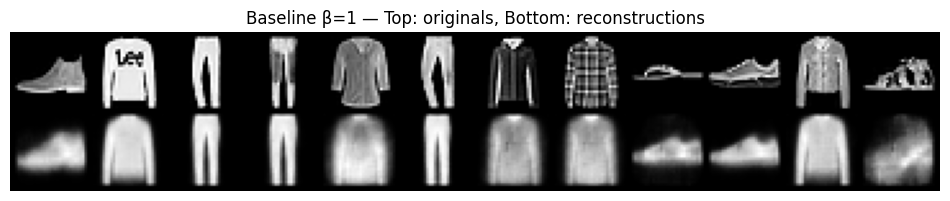

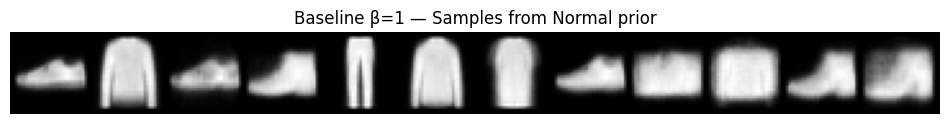

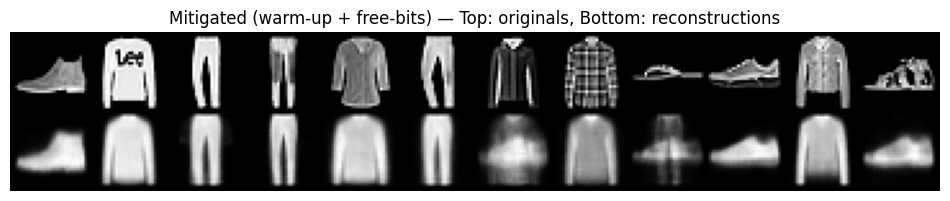

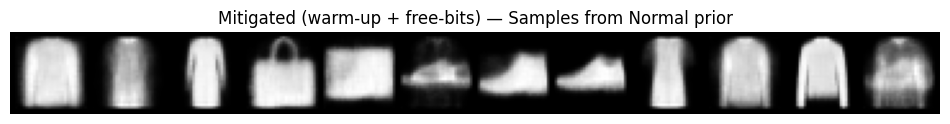

In [18]:
# --- Reconstructions and prior samples for both models ---
@torch.no_grad()
def show_recon_and_samples(vae, title, n=12):
    vae.eval()
    # Recon
    x, _ = next(iter(val_loader))
    x = x[:n].to(device)
    x_hat, _, _ = vae(x)
    # Samples from Normal prior
    z = torch.randn(n, LATENT_DIM, device=device)
    s = vae.decode(z)

    grid = vutils.make_grid(torch.cat([x, x_hat], dim=0), nrow=n, normalize=True, scale_each=True)
    plt.figure(figsize=(n*1.0, 2.5))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)), cmap="gray")
    plt.axis("off"); plt.title(f"{title} — Top: originals, Bottom: reconstructions"); plt.show()

    grid_s = vutils.make_grid(s, nrow=n, normalize=True, scale_each=True)
    plt.figure(figsize=(n*1.0, 1.25))
    plt.imshow(np.transpose(grid_s.cpu().numpy(), (1,2,0)), cmap="gray")
    plt.axis("off"); plt.title(f"{title} — Samples from Normal prior"); plt.show()

show_recon_and_samples(vae_base, "Baseline β=1")
show_recon_and_samples(vae_warm, "Mitigated (warm-up + free-bits)")
